In [1]:
import json
import requests

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error


%matplotlib inline

Using TensorFlow backend.


In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
bitcoin_history_prices = pd.DataFrame(json.loads(res.content)['Data'])
bitcoin_history_prices = bitcoin_history_prices.set_index('time')
bitcoin_history_prices.index = pd.to_datetime(bitcoin_history_prices.index, unit='s')



In [3]:
bitcoin_history_prices.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2014-01-08,938.84,966.90,858.90,879.90,14094.75,12942254.98
2014-01-09,936.95,964.64,866.55,938.84,14414.95,13202619.46
2014-01-10,957.76,964.84,905.88,936.95,6351.48,5909107.79
2014-01-11,1005.32,1010.84,935.00,957.76,11181.63,10948175.25
2014-01-12,939.79,1022.67,922.07,1005.32,9931.11,9620090.09


The close column is the closing price for Bitcoin for that day. It is the only value we care about.

# Splitting the data into train-test sets

In [4]:

target_col = 'close'
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(bitcoin_history_prices, test_size=0.1)

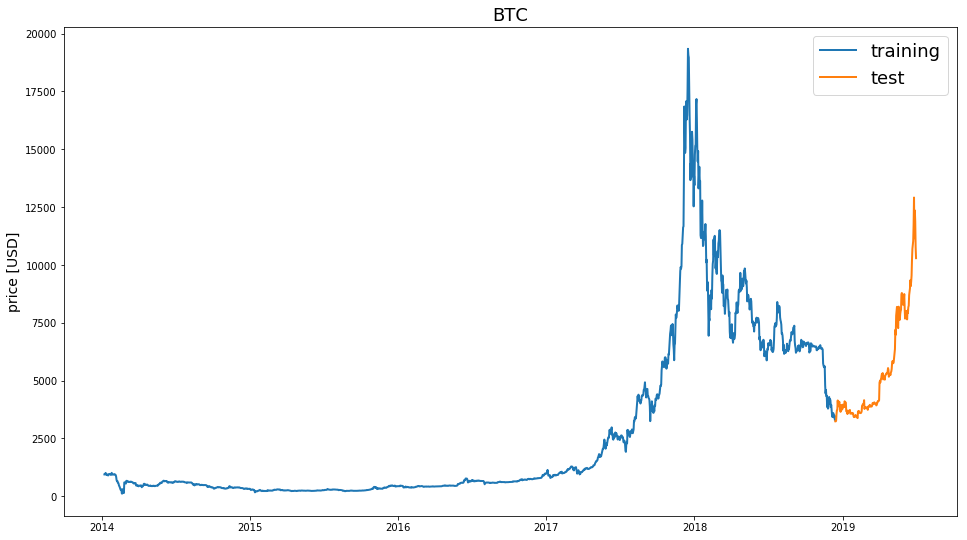

In [5]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

line_plot(train[target_col], test[target_col], 'training', 'test', title='BTC')

# Normalizing the data
We split the data into windows of 7 days and within each window we normalised the data to zero base, i.e. the first entry of each window is 0 and all other values represent the change with respect to the first value. Hence, I am predicting price changes, rather than absolute price. 

In [6]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with respect to first entry. """
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    """ Normalise dataframe column-wise min/max. """
    return (df - df.min()) / (data.max() - df.min())

def extract_window_data(df, window_len=7, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of len `window_data`.
    
        :param window_len: Size of window
        :param zero_base: If True, the data in each window is normalised to reflect changes
            with respect to the first entry in the window (which is then always 0)
    """
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)



def prepare_data(df, target_col, window_len=7, zero_base=True, test_size=0.2):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size=test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    # extract targets
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test


def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model




In [7]:
np.random.seed(1986)

# data params
window_len = 7
test_size = 0.1
zero_base = True

# model params
lstm_neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [8]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    bitcoin_history_prices, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0694
Epoch 2/50
1794/1794 [==============================] - 2s 1ms/step - loss: 0.0458
Epoch 3/50
1794/1794 [==============================] - 2s 1ms/step - loss: 0.0410
Epoch 4/50
1794/1794 [==============================] - 2s 1ms/step - loss: 0.0367
Epoch 5/50
1794/1794 [==============================] - 2s 1ms/step - loss: 0.0369
Epoch 6/50
1794/1794 [==============================] - 2s 1ms/step - loss: 0.0351
Epoch 7/50
1794/1794 [==============================] - 2s 1ms/step - loss: 0.0356
Epoch 8/50
1794/1794 [==============================] - 2s 1ms/step - loss: 0.0338
Epoch 9/50
1794/1794 [==============================] - 2s 1ms/step - loss: 0.0346
Epoch 10/50
1794/1

# Graphing predicted prices vs actual prices

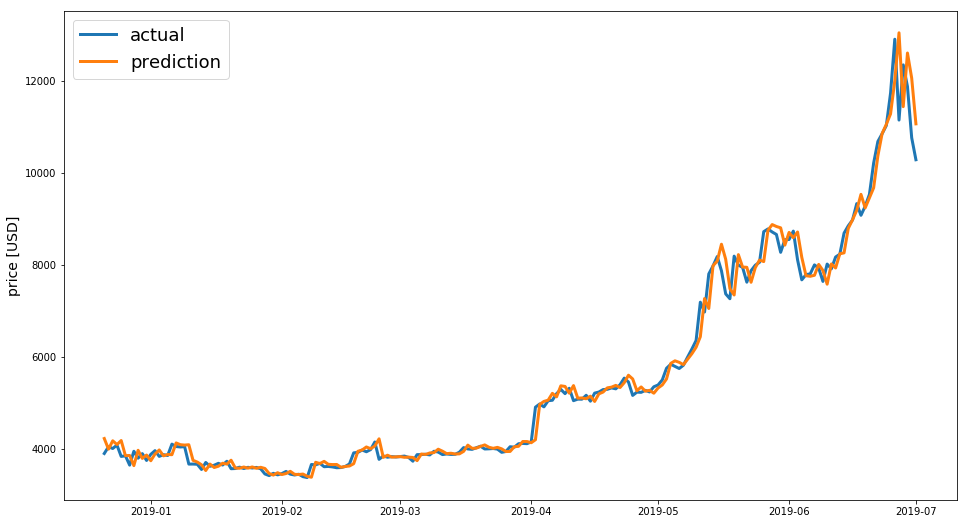

In [9]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

mean_absolute_error(preds, y_test)

preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'actual', 'prediction', lw=3)

# Zoming in the last 30 days

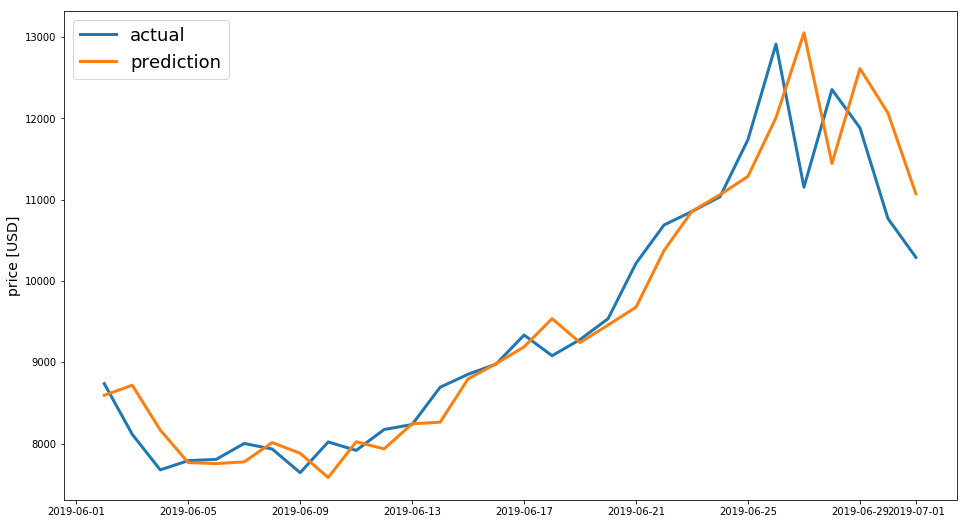

In [10]:
n_points = 30

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction', lw=3)

As you can see the prediction seems to be a 1 day shifted version of the actual price. To make this even more clear lets shift it by a day and do the comparison again.

In [11]:
actual_returns = targets.pct_change()[1:]
predicted_returns = preds.pct_change()[1:]

def dual_line_plot(line1, line2, line3, line4, label1=None, label2=None, title='', lw=2):
    import matplotlib.dates as mdates
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 9))
    ax1.plot(line1, label=label1, linewidth=lw)
    ax1.plot(line2, label=label2, linewidth=lw)
    ax2.plot(line3, label=label1, linewidth=lw)
    ax2.plot(line4, label=label2, linewidth=lw)
    ax2.set_xticks(ax1.get_xticks())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.set_ylabel('daily returns', fontsize=14)
    ax2.legend(loc='best', fontsize=18);

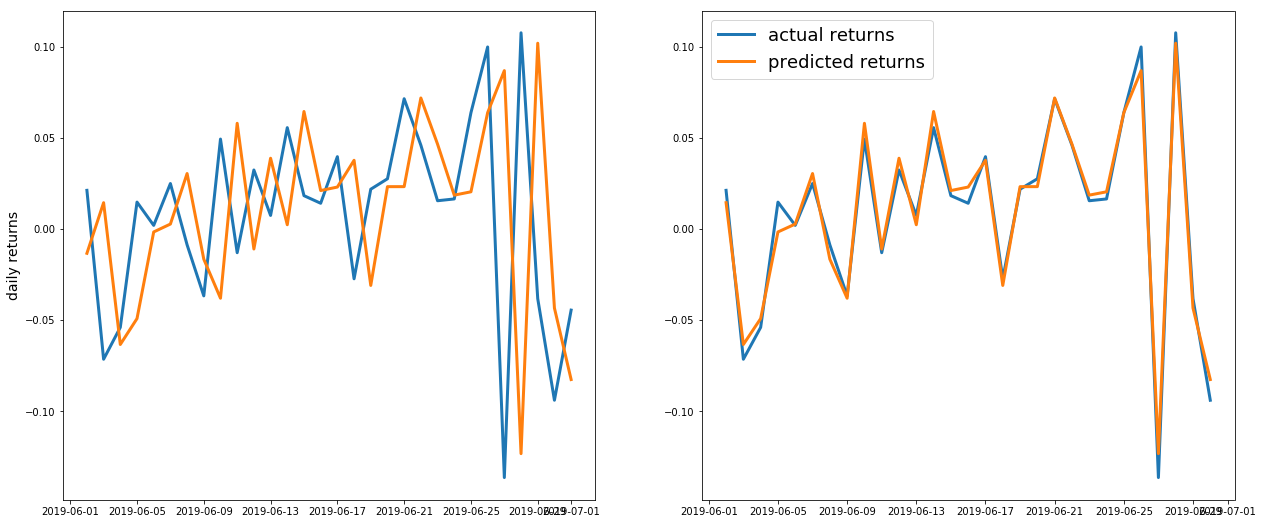

In [12]:
dual_line_plot(actual_returns[-n_points:],
          predicted_returns[-n_points:],
          actual_returns[-n_points:][:-1],
          predicted_returns[-n_points:].shift(-1),
          'actual returns', 'predicted returns', lw=3)

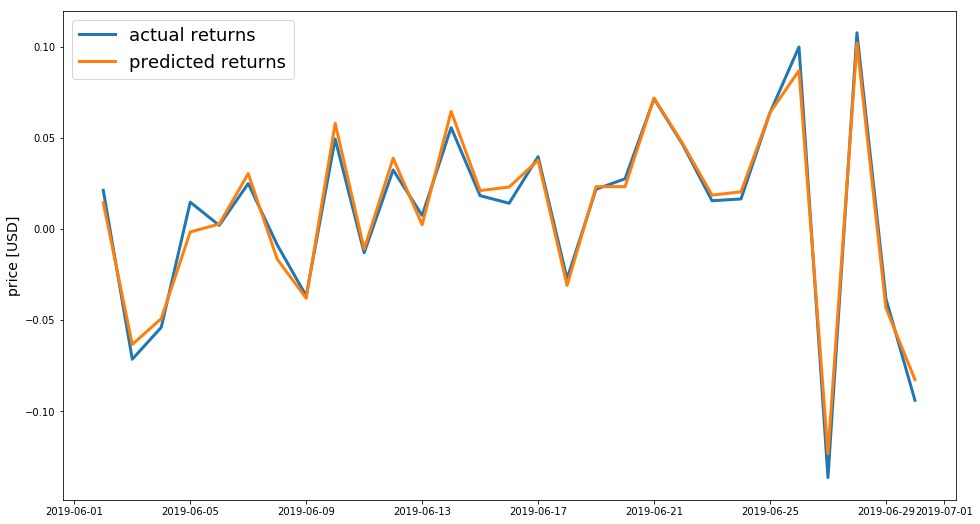

In [13]:
line_plot(actual_returns[-n_points:][:-1], predicted_returns[-n_points:].shift(-1),
           'actual returns', 'predicted returns', lw=3)

# Correlation Plot
Lets create two correlation plots. One for prediction vs actual prices and the second for a 1-day shifted prediction vs actual prices

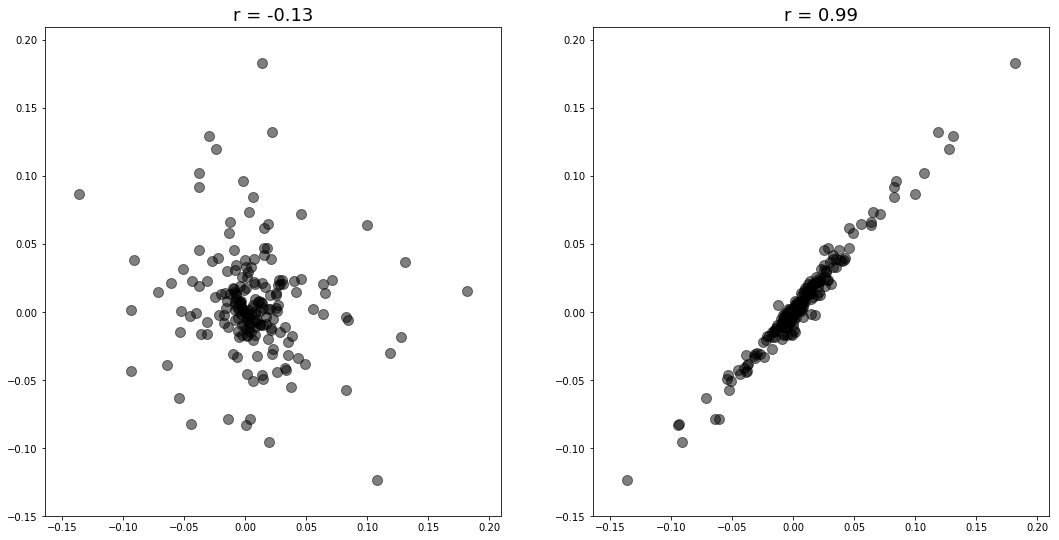

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# actual correlation
corr = np.corrcoef(actual_returns, predicted_returns)[0][1]
ax1.scatter(actual_returns, predicted_returns, color='k', marker='o', alpha=0.5, s=100)
ax1.set_title('r = {:.2f}'.format(corr), fontsize=18)

# shifted correlation
shifted_actual = actual_returns[:-1]
shifted_predicted = predicted_returns.shift(-1).dropna()
corr = np.corrcoef(shifted_actual, shifted_predicted)[0][1]
ax2.scatter(shifted_actual, shifted_predicted, color='k', marker='o', alpha=0.5, s=100)
ax2.set_title('r = {:.2f}'.format(corr), fontsize=18);